# Identify family interactions based on if they shared the same objects

In [76]:
%matplotlib inline

import os, re, glob, datetime, json
from os.path import join as opj
import pandas as pd
import numpy as np
import scipy.stats
from tqdm import tqdm
from datetime import datetime

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

import ohol_transitions as trans
import ohol_categories as cat
import ohol_objects as obj

## load data

In [77]:
baseDir = '../data/publicMapChangeData/bigserver2.onehouronelife.com/'

In [78]:
timestamp = 1588547119

In [79]:
data = pd.read_csv(baseDir + str(timestamp) + 'time_mapLog.txt')
data.head()

,startTime: 1588547119.04
0,0.00 -3910 119 0 2963621
1,0.01 -3909 121 0 2963721
2,0.05 -4226 -605 3907u0 -1
3,0.09 -3695 -76 148 2963628
4,0.12 -4237 -599 0 2963651


In [80]:
data[['time','locX','locY','obj','playerID']] = data[data.columns[0]].str.split(" ",expand=True)
data = data[['time','locX','locY','obj','playerID']]
data.head(n = 10)

,time,locX,locY,obj,playerID
0,0.00,-3910,119,0,2963621
1,0.01,-3909,121,0,2963721
2,0.05,-4226,-605,3907u0,-1
3,0.09,-3695,-76,148,2963628
4,0.12,-4237,-599,0,2963651
5,0.17,-4289,-706,224,2963746
6,0.25,-4225,-603,0,2963640
7,0.70,-3921,123,0,2963702
8,0.73,-4233,-570,807,2963747
9,0.99,-3134,290,1109,2963732


## Tag player by family name (from OHOL Name Files)

In [ ]:
dt_object = datetime.fromtimestamp(timestamp)
dt_object

In [ ]:
name_df1 = pd.read_csv('../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_04_Monday_names.txt', header = None)

In [ ]:
name_df2 = pd.read_csv('../data/publicLifeLogData/lifeLog_bigserver2.onehouronelife.com/2020_05May_03_Sunday_names.txt', header = None)

In [ ]:
name_df2[['playerID','first','last']] = name_df2[name_df2.columns[0]].str.split(" ",expand=True)
name_df2 = name_df2[['playerID','first','last']]
name_df2.head()

In [ ]:
name_df1[['playerID','first','last']] = name_df1[name_df1.columns[0]].str.split(" ",expand=True)
name_df1 = name_df1[['playerID','first','last']]
name_df1.head()

In [ ]:
name_df = pd.concat([name_df2, name_df])

In [ ]:
name_df.query('playerID == "2966859"')['last'].values

## df with family

In [ ]:
newdf = data.merge(name_df, on = "playerID")

## Approach 1: focus on location and family

build object id-name dict (in case we want to check what the obj is)

In [103]:
gsearch = lambda *args: glob.glob(opj(*args))
data_dir = '../../OneLifeData7/'
obj_dir = opj(data_dir, 'objects')
obj_files = gsearch(obj_dir, '*txt')

print(*obj_files[:5], sep='\n')

../../OneLifeData7/objects/3644.txt
../../OneLifeData7/objects/1053.txt
../../OneLifeData7/objects/1735.txt
../../OneLifeData7/objects/3122.txt
../../OneLifeData7/objects/2228.txt


In [104]:
str_extract = lambda pattern, s: re.search(pattern, s).group(0)
int_extract = lambda pattern, s: int(str_extract(pattern, s))
obj_dict = {}
all_obj = {}
for o in obj_files:
    is_obj = re.search('nextObjectNumber|groundHeat', o) is None
    
    if is_obj:
        o_num = int_extract('[0-9]+(?=.txt)', o)
        o_data = obj.read_obj(o_num)
        obj_dict[o_num] = o_data['mapChance']
        all_obj[o_num] = o_data['name']

find family from output data

In [105]:
fam= pd.read_csv('../2_demographics/outputs/family_playerID.tsv', sep = '\t')

In [161]:
def find_fam(playerId):
    playerId = int(playerId)
    family = fam.loc[fam['playerID'] == playerId,'family'].tolist()

    if len(family):    
        fam_name = family[0].split('-')[-1]
    else:
        fam_name = fam_name = "UnKnown"
    
    return fam_name

In [106]:
fam.head()

,Unnamed: 0,playerID,family
0,0,6160151,time-1592284232_eve-3080067_name-PICKLE
1,1,6160181,time-1592284232_eve-3080067_name-PICKLE
2,2,6160178,time-1592284232_eve-3080067_name-PICKLE
3,3,6160175,time-1592284232_eve-3080067_name-PICKLE
4,4,6160171,time-1592284232_eve-3080067_name-PICKLE


check if every player has a last name (No! Strange!)

In [110]:
for i in data['playerID'].unique():
    i = int(i)
    if (i != -1) and (i != 0):
        family = fam.query('playerID == @i')['family'].values
        if len(family):
            family_name = family[0].split('-')[-1]
            print(i, family_name)
        else:
            print(i)
        

2963621 JANE
2963721
2963628
2963651 BOB
2963746
2963640
2963702
2963747
2963732
2963724
2963642 GENIER
2963725
2963659 JANE
2963753 BOB
2963648 GENIER
2963692
2963741 GENIER
2963730
2963737
2963654 JANE
2963750
2963660
2963704
2963748
2963623 GENIER
2963749
2963599
2963688
2963671 JANE
2963647 GENIER
2963728
2963729
2963708
2963743
2963742
2963605
2963711 BOB
2963731
2963751
2963738
2963740
2963744
2963705
2963703
2963752
2963759
2963754
2963735
2963734
2963638
2963643 BOB
2963745
2963757
2963760
2963762
2963767
2963772
2963774
2963775 JANE
2963776
2963777
2963768
2963769
2963770
2963771
2963778
2963779
2963786
2963781
2963785
2963780 BOB
2963789
2963782
2963788
2963787
2963783
2963791
2963793
2963784
2963792
2963800
2963806
2963797
2963796 BOB
2963805
2963795 GENIER
2963807
2963803
2963799
2963802
2963804
2963808
2963810 GENIER
2963809 GENIER
2963812
2963801
2963814
2963813
2963811 JANE
2963819
2963820
2963822
2963824
2963825
2963827 BOB
2963828 BOB
2963815
2963830
2963816
2963826
29

2964795 BOB
2964812
2964806
2964794
2964796
2964811 JANE
2964803 BOB
2964805
2964814
2964815
2964807
2964808
2964809
2964810
2964818 BOB
2964820 BOB
2964813 JANE
2964823
2964827 JANE
2964828 JANE
2964825
2964816
2964821 JANE
2964822
2964824
2964819 BOB
2964830 BOB
2964832
2964829
2964831 JANE
2964833 JANE
2964835
2964837 BOB
2964836
2964839 JANE
2964834
2964841
2964840
2964843
2964842
2964848
2964845
2964838 BOB
2964847 GENIER
2964849
2964850
2964851
2964852 GENIER
2964853
2964854
2964856
2964857 JANE
2964858
2964860
2964859
2964861
2964865 BOB
2964864
2964868
2964863 BOB
2964862 JANE
2964872
2964873
2964874 BOB
2964875
2964878
2964870 GENIER
2964880
2964867
2964866
2964869
2964881
2964879
2964877 BOB
2964882
2964884 JANE
2964883 JANE
2964885
2964886
2964887
2964888
2964889
2964892
2964893
2964890 JANE
2964895
2964896
2964894
2964903 JANE
2964898 BOB
2964899
2964902
2964905 BOB
2964908 BOB
2964909
2964901
2964904
2964906 BOB
2964913
2964914
2964916
2964917
2964907 BOB
2964891 JANE
2964

2965848
2965846
2965850
2965849
2965853 JANE
2965852
2965851
2965856
2965854 JANE
2965857
2965860 JANE
2965858
2965855
2965859
2965871
2965872
2965873
2965870
2965862
2965863
2965874
2965868
2965877
2965879
2965864
2965880
2965861
2965885
2965886
2965887 JANE
2965888
2965881 JANE
2965878
2965889
2965890
2965891
2965894
2965893
2965898 JANE
2965900
2965896
2965897
2965895
2965907
2965899
2965909
2965904
2965912 JANE
2965905
2965906
2965915
2965914
2965908 BOB
2965910 JANE
2965911 JANE
2965913
2965921
2965916
2965917 JANE
2965922
2965927
2965918
2965919
2965931
2965929
2965932
2965934
2965933
2965924
2965923
2965925
2965926
2965928 JANE
2965941
2965920 JANE
2965930
2965944 JANE
2965935
2965936 JANE
2965940
2965938 JANE
2965937
2965939 JANE
2965946
2965942
2965943
2965947
2965949 JANE
2965948 BOB
2965952
2965958 JANE
2965962 JANE
2965954 JANE
2965953
2965945
2965955
2965950
2965951 JANE
2965960 JANE
2965963
2965959
2965961
2965965 JANE
2965966 JANE
2965964 BOB
2965970
2965967
2965968 JANE

nan

## record connection in a dataframe

In [261]:
def plot_connection_through_obj(locX, locY, bigdf):
    loc_data = data.query('(locX == @locX) and (locY == @locY)').copy()
    #find previous player and object
    previous_obj = loc_data['obj'].values
    previous_obj = np.append(np.nan, previous_obj[0:-1])
    previous_player = loc_data['playerID'].values
    previous_player = np.append("0", previous_player[0:-1])
#     previous_fam = loc_data['last'].values
#     previous_fam = np.append(np.nan, previous_fam[0:-1])
    loc_data['previous_obj'] = previous_obj
    loc_data['previous_playerID'] = previous_player
#     loc_data['previous_fam'] = previous_fam
    #check connection
    connection_data = loc_data.query('(previous_obj!="0") \
     and (previous_playerID!=playerID) and (previous_playerID!="-1") and (playerID!="-1")')
    connection_data['weight'] = 1
    bigdf = pd.concat([bigdf, connection_data]).groupby(['playerID','previous_playerID'])['weight'].sum().reset_index()
#     connection_list = connection_data[['playerID','previous_playerID']].values.tolist()
#     G.add_edges_from(connection_list)
    
    return bigdf

In [262]:
bigdf = pd.DataFrame(columns = ['playerID','previous_playerID','weight'])
for i in tqdm(data['locX'].unique()[0:10]):
    for j in data['locY'].unique()[0:100]:
        bigdf = plot_connection_through_obj(i, j, bigdf)

        





  0%|          | 0/10 [00:00<?, ?it/s]/Users/dengwenning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/dengwenning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()




 10%|█         | 1/10 [00:11<01:41, 11.32s/it]



 20%|██        | 2/10 [00:26<01:39, 12.38s/it]



 30%|███       | 3/10 [00:36<01:22, 11.81s/it]



 40%|████      | 4/10 [00:47<01:08, 11

append family name for each player

In [271]:
bigdf_fam = bigdf.copy()
bigdf_fam['player_fam'] = bigdf_fam['playerID'].map(find_fam)
bigdf_fam['previous_player_fam'] = bigdf_fam['previous_playerID'].map(find_fam)
bigdf_fam.head(n=10)

,playerID,previous_playerID,weight,player_fam,previous_player_fam
0,2963621,0,5,JANE,UnKnown
1,2963623,0,1,GENIER,UnKnown
2,2963623,2963647,1,GENIER,GENIER
3,2963623,2963711,1,GENIER,BOB
4,2963628,0,1,UnKnown,UnKnown
5,2963638,0,4,UnKnown,UnKnown
6,2963638,2963724,1,UnKnown,UnKnown
7,2963640,0,5,UnKnown,UnKnown
8,2963640,2963648,1,UnKnown,GENIER
9,2963640,2963659,1,UnKnown,JANE


group by family

In [272]:
different_fam = bigdf_fam.query('previous_player_fam != player_fam').copy()
different_fam[['player_fam','previous_player_fam']]=np.sort(different_fam[['player_fam','previous_player_fam']],1)
different_fam = different_fam.groupby(['player_fam','previous_player_fam'])['weight'].sum().reset_index()
different_fam

,player_fam,previous_player_fam,weight
0,BOB,GENIER,43
1,BOB,JANE,99
2,BOB,UnKnown,868
3,GENIER,JANE,36
4,GENIER,UnKnown,359
5,JANE,UnKnown,1123


plot

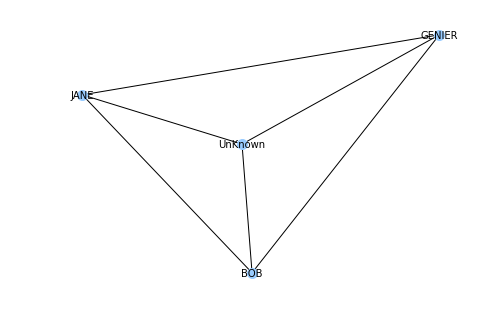

In [266]:
G2 = nx.from_pandas_edgelist(different_fam, 'player_fam', 'previous_player_fam', 'weight')
nx.draw(G2, with_labels= True, node_color='#99ccff', node_size=100, font_size=10)
plt.figure(figsize=(100,100))
plt.draw()
plt.show()

## Scratch

take one piece and check

In [258]:
locX = data['locX'].unique()[0]
locY = data['locY'].unique()[0]
loc_data = data.query('(locX == @locX) and (locY == @locY)').copy()
previous_obj = loc_data['obj'].values
previous_obj = np.append("0", previous_obj[0:-1])
previous_player = loc_data['playerID'].values
previous_player = np.append(np.nan, previous_player[0:-1])
loc_data['previous_obj'] = previous_obj
loc_data['previous_playerID'] = previous_player
connection_data = loc_data.query('(previous_obj!="0") \
 and (previous_playerID!=playerID) and (previous_playerID!="-1") and (playerID!="-1")')
# connection_data = connection_data.query('')
connection_list = connection_data[['playerID','previous_playerID']].values.tolist()
connection_data

['0' '857' '0' '2745' '0' '225' '226' '227' '623' '625' '790' '624u5'
 '624u4' '624u3' '624u2' '624u1' '624u0' '0' '395' '292' '0' '292' '0'
 '258' '260' '0' '1101' '1101u0' '1138' '1101u0' '1138' '0' '253' '258' '0'
 '258' '0' '292' '0' '2172' '0' '292' '0' '1099u1' '1099u0' '1100' '0'
 '660' '1099' '1099u7' '1099u6' '1099u5' '1099u4' '1099u3' '1099u2'
 '1099u1' '1099u0' '1100' '0' '3810' '3810u7' '3810u6' '0' '3810u6'
 '3810u5' '3810u4' '3810u3' '3810u2' '0' '1160' '0' '3810u2' '3810u1'
 '3810u0' '659' '0' '33' '0' '33' '0' '245' '251' '0' '33' '0' '251' '252'
 '0' '235' '0' '31' '0' '235' '253u0' '253u1' '0' '2172' '0' '236' '0'
 '235' '0' '548' '0' '235' '0' '2172' '0' '1202' '0' '852' '0' '1176u3'
 '1176u4' '1176' '0' '2172' '0' '1214' '0' '1217' '1220' '1225' '1222' '0'
 '1214' '0' '1217' '1220' '1217' '0' '852' '0' '3161' '0' '31' '0' '64'
 '67' '557' '0' '34' '0' '64' '67' '0' '34' '0' '64' '67' '557' '0' '227'
 '1117' '0' '1101' '1101u0' '1138' '0' '502' '0' '3810' '3810u7' '3

,time,locX,locY,obj,playerID,previous_obj,previous_playerID
58496,2695.13,-3910,119,0,2963759,857,2963724
183754,12353.70,-3910,119,790,2964212,625,2963970
366209,28334.30,-3910,119,624u5,2964819,790,2964212
391633,30112.41,-3910,119,624u4,2964836,624u5,2964819
392574,30199.65,-3910,119,624u2,2964869,624u3,2964836
427923,32969.21,-3910,119,292,2964887,395,2964843
442416,34070.12,-3910,119,1101u0,2964935,1101,2964993
445276,34078.03,-3910,119,1138,2964950,1101u0,2964935
446589,34213.36,-3910,119,0,2964959,1138,2964950
455328,35218.69,-3910,119,0,2965004,292,2964950


plot player

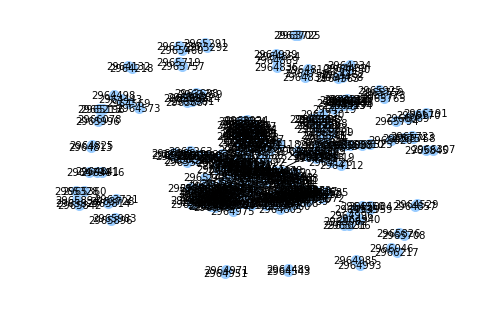

In [101]:
G = nx.from_pandas_edgelist(bigdf, 'playerID', 'previous_playerID', edge_attr='weight') 
nx.draw(G, with_labels= True, node_color='#99ccff', node_size=100, font_size=10)
plt.figure(figsize=(100,100))
plt.draw()
plt.show()

In [202]:
loc_data = data.query('(locX == "-3065") and (locY == "153")').copy()
#find previous player and object
previous_obj = loc_data['obj'].values
previous_obj = np.append(np.nan, previous_obj[0:-1])
previous_player = loc_data['playerID'].values
previous_player = np.append(np.nan, previous_player[0:-1])
#     previous_fam = loc_data['last'].values
#     previous_fam = np.append(np.nan, previous_fam[0:-1])
loc_data['previous_obj'] = previous_obj
loc_data['previous_playerID'] = previous_player
#     loc_data['previous_fam'] = previous_fam
#check connection
connection_data = loc_data.query\
('(obj=="0") and (previous_playerID!=playerID) and (previous_playerID!="-1") and (playerID!="-1")')
connection_list = connection_data[['playerID','previous_playerID']].values.tolist()
connection_data

,time,locX,locY,obj,playerID,previous_obj,previous_playerID


## Another Approach: look at object

In [553]:
newdf['time'] = newdf['time'].astype(float)
newdf = newdf.sort_values(by = 'time').reset_index()
# newdf['idx'] =newdf.index

In [554]:
newdf.head()

,index,time,locX,locY,obj,playerID,first,last
0,0,0.00,-3910,119,0,2963621,HOPE,LOVE
1,59,0.01,-3909,121,0,2963721,FIRYAL,LOVE
2,376,0.09,-3695,-76,148,2963628,JUSTIN,MORSE
3,433,0.12,-4237,-599,0,2963651,SUSAN,TEARS
4,574,0.17,-4289,-706,224,2963746,NEWBORN,TEARS


In [561]:
def find_connection_through_item(item, k):
    fam_list = []
    obj_data = newdf.query('obj == @item')
    locX = obj_data.iloc[k]['locX']
    locY = obj_data.iloc[k]['locY']
    time = obj_data.iloc[k]['time']
    orig_fam = obj_data.iloc[k]['last']
    fam_list = np.append(fam_list, orig_fam)


    fam_name = origFam
    while fam_name == origFam:
        try:
            identify_player = newdf.query('(locX == @locX) and (locY == @locY) and (time > @time)').iloc[0]
            player = identify_player['playerID']
            fam_name = identify_player['last']
            t = identify_player['time']
            identify_location = newdf.query('(playerID == @player) and (time > @t)').iloc[0]
            locX = identify_location['locX']
            locY = identify_location['locY']
            time = identify_location['time']
        except IndexError:
            fam_name = 'could not find'
            print('not enough data')
    fam_list = np.append(fam_list, fam_name)
    return fam_list

In [566]:
find_connection_through_item("441",1)

array(['LOVE', 'ROHER'],
      dtype='<U32')